### Using NFStream to process the PCAP files to have flow records in CSV file (active timeout =41 , decomposition wavelet levels = 5)

In [1]:
import nfstream
from nfstream import NFStreamer
import sys
import pandas as pd
import numpy as np
import numpy.typing as npt
import pywt
import os

from nfstream import NFPlugin

class WFPlugin(NFPlugin):
    
    def on_init(self, packet, flow):
        assert hasattr(self, "levels")
        assert hasattr(self, "active_timeout")

        # Pywt requires vector of length 2**level as input
        # set nbins to that number:
        self.nbins = 2**self.levels

        # Given `a` as max flow length calculate size of each bin:
        self.bin_size = self.active_timeout / 2**self.levels * 1000

        # Reserve a empty vectors for data i forward and backward direction
        flow.udps.forward = np.zeros(self.nbins).tolist()
        flow.udps.backward = np.zeros(self.nbins).tolist()

        # Save first packet timestamp that will be used to calc index
        # of time series bin
        flow.udps.first_packet_timestamp = packet.time  # timestamp in ms

    def on_update(self, packet, flow):
        # Calculate time in ms from first packet
        mstime_since_first_packet: int = packet.time - flow.udps.first_packet_timestamp

        # Calculate index of bin to put data into
        ibin, _ = divmod(mstime_since_first_packet, self.bin_size)

        # Put transport_size into timeseries depending on direction
        if packet.direction == 0:
            # src to dest
            flow.udps.forward[int(ibin)] += packet.transport_size
        else:
            # dst to src
            flow.udps.backward[int(ibin)] += packet.transport_size

    def on_expire(self, flow):
        # Calculate and add forward features
        f_p_k, f_u_k, f_sigma_k, f_S_k = self.calculate_wavelet_features(
            data=flow.udps.forward, level=self.levels
        )
        self.add_attrs_from_list(flow, f_p_k, "f_p_k")
        self.add_attrs_from_list(flow, f_u_k, "f_u_k")
        self.add_attrs_from_list(flow, f_sigma_k, "f_sigma_k")
        self.add_attrs_from_list(flow, f_S_k, "f_S_k")

        # Calculate and add backward features
        b_p_k, b_u_k, b_sigma_k, b_S_k = self.calculate_wavelet_features(
            data=flow.udps.backward, level=self.levels
        )
        self.add_attrs_from_list(flow, b_p_k, "b_p_k")
        self.add_attrs_from_list(flow, b_u_k, "b_u_k")
        self.add_attrs_from_list(flow, b_sigma_k, "b_sigma_k")
        self.add_attrs_from_list(flow, b_S_k, "b_S_k")

        # Delete temporary variables
        del flow.udps.forward
        del flow.udps.backward
        del flow.udps.first_packet_timestamp

    @staticmethod
    def add_attrs_from_list(flow, values, attr):
        """Adds new attributes to flow.udps from a list of `values`. Name of
        attributes are generated by adding `attr` and `number`
        """
        for i, value in enumerate(values):
            setattr(flow.udps, f"{attr}_{i}", value)

    @staticmethod
    def calculate_wavelet_features(
        data: npt.NDArray[np.float64], level
    ) -> tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
        """Calculate wavelet features based on [1].

        Args:
            data
                Data. Will be padded to 2**level.

        Returns:
            4 vectors of shape: (level, ), these vectors are:
            - `p_k` (Relative wavelet energy vector),
            - `u_k` (Absolute mean of detail coefficients),
            - `sigma_k` (Std. deviation of detail coefficients),
            - `S_k` (Shannon entropy)
        """
        data = np.pad(data, (0, max(0, 2**level - len(data))))
        coeffs = pywt.wavedec(data, "haar", level=level)

        # Extract detail coefficients and approximation coefficients
        detail_coeffs = coeffs

        # Prepare for feature calculation
        E_k = np.array([np.sum(np.square(c)) for c in detail_coeffs])
        E_total = np.sum(E_k)

        # Relative wavelet energy
        p_k = E_k / (E_total + 1e-7)

        # Calculate Shannon entropy for each level
        S_k = np.array([
            -np.sum((c**2 / (np.sum(c**2) + 1e-7)) * np.log((c**2 / (np.sum(c**2) + 1e-7)) + 1e-7))
            for c in detail_coeffs
        ])

        # Absolute mean of coefficients
        u_k = np.array([np.mean(np.abs(c)) for c in detail_coeffs])

        # Standard deviation of coefficients
        sigma_k = np.array([np.std(c) for c in detail_coeffs])

        return (
            p_k,
            u_k,
            sigma_k,
            S_k,
        )

def process_pcap_NF(pcap_directory: str):
    
    pcap_files = [f for f in os.listdir(pcap_directory) if f.endswith('.pcap')]
    print(f"Found {len(pcap_files)} .pcap files. Processing...")

    for filename in pcap_files:
        path = os.path.join(pcap_directory, filename)

        streamer = nfstream.NFStreamer(source=path,
                                       statistical_analysis=True,
                                       splt_analysis=255,
                                       idle_timeout=1200,
                                       active_timeout=41,
                                       accounting_mode=2,
                                       udps=[WFPlugin(active_timeout=41, levels=5)],
                                       n_dissections=20,
                                       n_meters=1,
        )

        os.makedirs("VNAT/WF", exist_ok=True)
        output_folder = os.path.join(os.path.dirname(path), "WF")

        output_csv = os.path.join(output_folder, os.path.splitext(os.path.basename(path))[0] + ".csv")

        streamer.to_csv(output_csv)


if __name__ == '__main__':
    pcap_directory =  "VNAT"
    print(f"Starting NFStream v{nfstream.__version__}")
    process_pcap_NF(pcap_directory)
    print("All files processed.")

Starting NFStream v6.5.4b
Found 165 .pcap files. Processing...
All files processed.


### Merge the CSV files into one large CSV

In [2]:
import os
import pandas as pd

directory = "VNAT/WF"

dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):  
        df = pd.read_csv(os.path.join(directory, filename),low_memory=False)
        
        if 'nonvpn' in filename.lower():
            df['label'] = 'NoVPN'
        else:    
            df['label'] = 'VPN'
        df['source_file']=filename
        dataframes.append(df)

df_large = pd.concat(dataframes, ignore_index=True)

df_large.to_csv("VNAT/WF/flows.csv", index=False)

### Read the large CSV in and assign categories based on the source file names

In [3]:
import pandas as pd

df = pd.read_csv("VNAT/WF/flows.csv",low_memory=False)

category_mapping = {
    'skype': 'Chat',
    'vimeo': 'Streaming',
    'netflix': 'Streaming',
    'youtube': 'Streaming',
    'ssh': 'Command & Control',
    'rdp': 'Command & Control',
    'sftp': 'File Transfer',
    'rsync': 'File Transfer',
    'scp': 'File Transfer',
    'voip': 'VoIP'
}

def assign_category(source_file):
    for keyword, category in category_mapping.items():
        if keyword in source_file.lower():
            return category
    return 'Unknown' 

df['category'] = df['source_file'].apply(assign_category)
df['category'].value_counts()

/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_61321/1849199583.py:3: DtypeWarning: Columns (86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("VNAT/WF/flows.csv")


category
File Transfer        17966
Command & Control    17585
Chat                 11679
Streaming             3494
VoIP                  1223
Name: count, dtype: int64

In [6]:
df.to_csv('VNAT/WF/flows_extra_labelled.csv', index=False)

###  CDF to see how the samples distribute across flow duration and packet count

Number of rows before filtering: 51947
Number of rows after filtering: 51947
CDF at 41.0 seconds: 1.0


/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_61321/3347630153.py:7: DtypeWarning: Columns (86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv('VNAT/WF/flows_extra_labelled.csv')


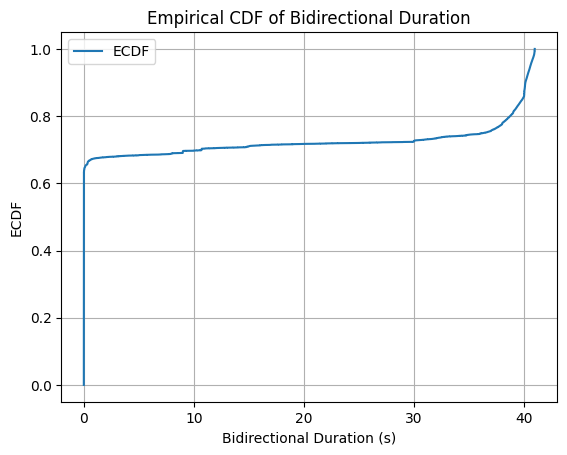

CDF at 8000 packets: 0.9931276108341195


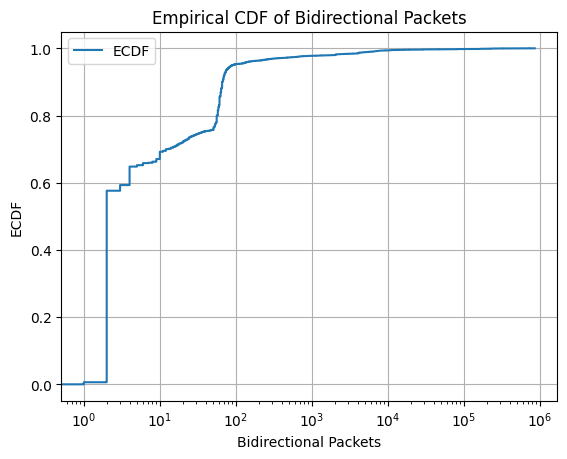

18877


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Load dataset
filtered_df = pd.read_csv('VNAT/WF/flows_extra_labelled.csv')
print(f"Number of rows before filtering: {df.shape[0]}")


print(f"Number of rows after filtering: {filtered_df.shape[0]}")
data_duration = filtered_df['bidirectional_duration_ms'].dropna() / 1000  # Drop NaN values if any

ecdf_duration = ECDF(data_duration)

value_duration = 41.0  
print(f"CDF at {value_duration} seconds: {ecdf_duration(value_duration)}")

plt.step(ecdf_duration.x, ecdf_duration.y, label="ECDF")
# plt.xscale('log') 
plt.xlabel('Bidirectional Duration (s)')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Duration')
plt.legend()
plt.grid(True)
plt.show()

###################################################################

data_packets = filtered_df['bidirectional_packets'].dropna()  

ecdf_packets = ECDF(data_packets)

value_packets = 8000  
print(f"CDF at {value_packets} packets: {ecdf_packets(value_packets)}")

plt.step(ecdf_packets.x, ecdf_packets.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Packets')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Packets')
plt.legend()
plt.grid(True)
plt.show()

print(filtered_df['bidirectional_duration_ms'].value_counts().max())

In [8]:
data_duration.describe()

count    51947.000000
mean        11.371808
std         17.391648
min          0.000000
25%          0.000000
50%          0.001000
75%         36.364500
max         40.999000
Name: bidirectional_duration_ms, dtype: float64

In [9]:
data_packets.describe()

count     51947.000000
mean        733.502762
std       12444.485317
min           1.000000
25%           2.000000
50%           2.000000
75%          36.000000
max      857900.000000
Name: bidirectional_packets, dtype: float64

### CDF with filter out any flows that have less than 20 packets

Number of rows before filtering: 51947
Number of rows after filtering: 14617
CDF at 41.0 seconds: 1.0


/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_61321/1993777218.py:7: DtypeWarning: Columns (86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv('VNAT/WF/flows_extra_labelled.csv')


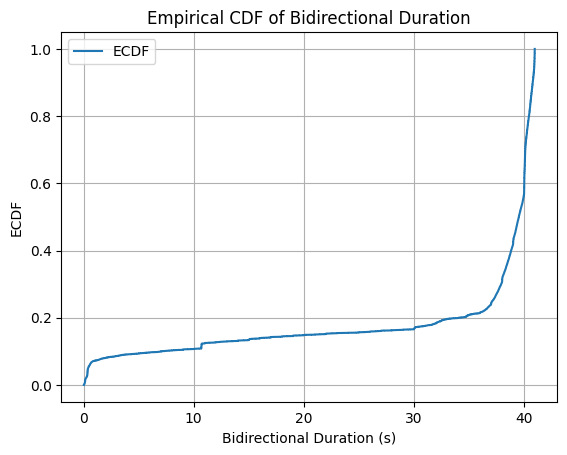

CDF at 8000 packets: 0.9755763836628583


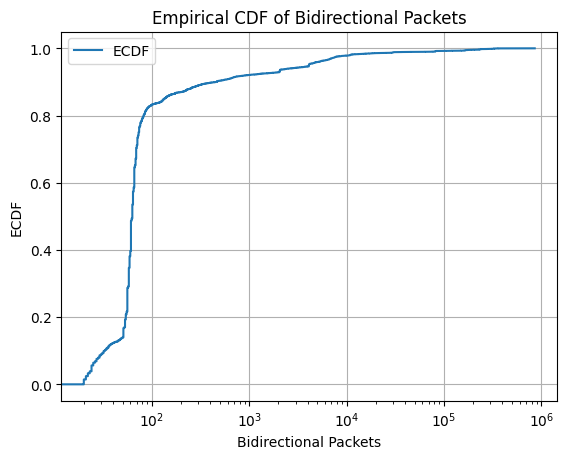

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Load dataset
filtered_df = pd.read_csv('VNAT/WF/flows_extra_labelled.csv')
print(f"Number of rows before filtering: {df.shape[0]}")

filtered_df = filtered_df[filtered_df['bidirectional_packets'] > 19]

print(f"Number of rows after filtering: {filtered_df.shape[0]}")

data_duration = filtered_df['bidirectional_duration_ms'].dropna() / 1000 
ecdf_duration = ECDF(data_duration)

value_duration = 41.0  
print(f"CDF at {value_duration} seconds: {ecdf_duration(value_duration)}")

plt.step(ecdf_duration.x, ecdf_duration.y, label="ECDF")
# plt.xscale('log') 
plt.xlabel('Bidirectional Duration (s)')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Duration')
plt.legend()
plt.grid(True)
plt.show()

###################################################################

data_packets = filtered_df['bidirectional_packets'].dropna() 

ecdf_packets = ECDF(data_packets)

value_packets = 8000  
print(f"CDF at {value_packets} packets: {ecdf_packets(value_packets)}")

plt.step(ecdf_packets.x, ecdf_packets.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Packets')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Packets')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
data_duration.describe()

count    14617.000000
mean        33.893629
std         12.570976
min          0.014000
25%         37.156000
50%         39.554000
75%         40.285000
max         40.999000
Name: bidirectional_duration_ms, dtype: float64

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(data_packets.describe())

count    14617.00
mean      2599.00
std      23357.13
min         20.00
25%         56.00
50%         63.00
75%         73.00
max     857900.00
Name: bidirectional_packets, dtype: float64
